# Linear Regression

In this notebook, I build out some linear regression models to model policy impacts. This is using what I call a "bin" model - where independent variables are one-hot encoded based on how long it was since the given policy was implemented. The choice of bins is left as a hyperparameter optimization task. 

Here is the schema for the datasets:

| info<br>state |  <br>county  | <br>date | <br>num_new_cases | policy name<br>0-7| <br>8-14 | <br>15-999|
| ------------- | ------------ | -------  | ----------------- | ------ | ------ | ------ |
| state   | county  | date - 1 | # of new cases | 0 | 0 | 0 |
| state   | county  | policy enacted today | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 1 | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 2 | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 3 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 4 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 5 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 6 | # of new cases | 0 | 0 | 1 |
| state   | county  | date + 7 | # of new cases | 0 | 0 | 1 |
| state   | county  | date + 8 | # of new cases | 0 | 0 | 1 |
|    |   | ... |  |  |  | |
| state   | county  | today | # of new cases | 0 | 0 | 1 |



Run this script to generate the datasets. Should take about 4 hours with the current selection of bins.

In [1]:
# !python ./scripts/linreg_single_policy.py --run_what generate_dataset

Run this script to run linear regression - should take about an hour

In [2]:
# !python ./scripts/linreg_single_policy.py --run_what run_models

In [3]:
from covid_project.regression_funcs_bins import collect_all_regression_results_to_df, plot_rsquared_heatmap, BINS
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

path = "./data/regression_results_single_policy_bins/"


df = collect_all_regression_results_to_df(path)

# 1. Check significance

In [4]:

def pivot_df_to_pvalues(data, dep_var, bins='[(0, 14), (15, 999)]'):
    def _color_sig_values(val, p=0.05):
        color = 'green' if val < p else ''
        return 'color: ' + color

    data = data[(data['dep_var']==dep_var)]
    data = data[['policy', 'bins_list', 'bin', 'p_value']]
    data = data.drop_duplicates()
    data = data.set_index('policy')
    data = data[data['bins_list']==bins]
    data = data.pivot(columns='bin')['p_value']
    data = data.sort_index()
    data = data.style.map(_color_sig_values)
    return data

## 1.1 New cases

In [5]:
for b in BINS:
    d = pivot_df_to_pvalues(df, 'new_cases_1e6', str(b))
    display(d)

bin,0-7,8-999,const
policy,,,
childcare - start - county,0.000000,0.000000,0.000000
childcare - start - state,0.471077,0.000000,0.000000
childcare - stop - county,0.001411,0.000015,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.051133,0.000143,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.019950,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.063444,0.000000,0.000000


bin,0-14,15-999,const
policy,,,
childcare - start - county,0.000000,0.000000,0.000000
childcare - start - state,0.180964,0.000000,0.000000
childcare - stop - county,0.000354,0.000033,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.007069,0.000055,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000052,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.031174,0.000000,0.000000


bin,0-20,21-999,const
policy,,,
childcare - start - county,0.000000,0.000000,0.000000
childcare - start - state,0.232960,0.000000,0.000000
childcare - stop - county,0.000547,0.000044,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.001395,0.000023,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.024641,0.000000,0.000000


bin,0-7,15-999,8-14,const
policy,,,,
childcare - start - county,0.000000,0.000000,0.000000,0.000000
childcare - start - state,0.875802,0.000000,0.028446,0.000000
childcare - stop - county,0.001411,0.000033,0.069357,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.051133,0.000055,0.063171,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.020161,0.000000,0.000301,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.062314,0.000000,0.351611,0.000000


bin,0-7,22-999,8-21,const
policy,,,,
childcare - start - county,0.000000,0.000000,0.000000,0.000000
childcare - start - state,0.011482,0.000000,0.002598,0.000000
childcare - stop - county,0.001411,0.000039,0.092903,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.051133,0.000020,0.008626,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.020186,0.000000,0.000001,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.061567,0.000000,0.288237,0.000000


bin,0-7,15-28,29-60,61-999,8-14,const
policy,,,,,,
childcare - start - county,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
childcare - start - state,0.013745,0.833579,0.000000,0.000000,0.925384,0.000000
childcare - stop - county,0.001411,0.570901,0.042148,0.000001,0.069357,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.051131,0.009185,0.000084,0.000000,0.063169,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.020411,0.000002,0.000000,0.000000,0.000317,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.062509,0.624180,0.001589,0.000000,0.327343,0.000000


## 1.2 New cases (7-day average)

In [6]:
for b in BINS:
    d = pivot_df_to_pvalues(df, 'new_cases_7day_1e6', str(b))
    display(d)

bin,0-7,8-999,const
policy,,,
childcare - start - county,0.000000,0.000000,0.000000
childcare - start - state,0.047310,0.000000,0.000000
childcare - stop - county,0.000000,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.001401,0.000361,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.002392,0.000000,0.000000


bin,0-14,15-999,const
policy,,,
childcare - start - county,0.000000,0.000000,0.000000
childcare - start - state,0.689135,0.000000,0.000000
childcare - stop - county,0.000000,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.000008,0.000081,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.000017,0.000000,0.000000


bin,0-20,21-999,const
policy,,,
childcare - start - county,0.000000,0.000000,0.000000
childcare - start - state,0.519068,0.000000,0.000000
childcare - stop - county,0.000000,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.000000,0.000020,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.000042,0.000000,0.000000


bin,0-7,15-999,8-14,const
policy,,,,
childcare - start - county,0.000000,0.000000,0.000000,0.000000
childcare - start - state,0.294353,0.000000,0.082724,0.000000
childcare - stop - county,0.000000,0.000000,0.000009,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.001401,0.000081,0.001689,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.002543,0.000000,0.008205,0.000000


bin,0-7,22-999,8-21,const
policy,,,,
childcare - start - county,0.000000,0.000000,0.000000,0.000000
childcare - start - state,0.000000,0.000000,0.000117,0.000000
childcare - stop - county,0.000000,0.000000,0.000043,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.001401,0.000016,0.000009,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.002349,0.000000,0.010429,0.000000


bin,0-7,15-28,29-60,61-999,8-14,const
policy,,,,,,
childcare - start - county,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
childcare - start - state,0.000004,0.609374,0.000000,0.000000,0.132170,0.000000
childcare - stop - county,0.000000,0.619075,0.000304,0.000000,0.000009,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.001401,0.000010,0.000000,0.000000,0.001689,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.002556,0.760967,0.000025,0.000000,0.006983,0.000000


## 1.3 New deaths

In [7]:
for b in BINS:
    d = pivot_df_to_pvalues(df, 'new_deaths_1e6', str(b))
    display(d)

bin,0-7,8-999,const
policy,,,
childcare - start - county,0.464245,0.000971,0.000000
childcare - start - state,0.051892,0.000000,0.000000
childcare - stop - county,0.319698,0.013815,0.000000
childcare - stop - state,0.000001,0.000000,0.000000
construction - start - county,0.866187,0.005291,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.006200,0.001932,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.989294,0.404721,0.000000


bin,0-14,15-999,const
policy,,,
childcare - start - county,0.980875,0.000588,0.000000
childcare - start - state,0.007475,0.000000,0.000000
childcare - stop - county,0.006995,0.032103,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.748981,0.005538,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.005546,0.002764,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.278034,0.301975,0.000000


bin,0-20,21-999,const
policy,,,
childcare - start - county,0.653607,0.000347,0.000000
childcare - start - state,0.000250,0.000000,0.000000
childcare - stop - county,0.002734,0.044385,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.667900,0.005815,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.007797,0.003194,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.237211,0.274524,0.000000


bin,0-7,15-999,8-14,const
policy,,,,
childcare - start - county,0.464518,0.000588,0.455152,0.000000
childcare - start - state,0.079256,0.000000,0.033986,0.000000
childcare - stop - county,0.319697,0.032103,0.003921,0.000000
childcare - stop - state,0.000001,0.000000,0.000586,0.000000
construction - start - county,0.866187,0.005538,0.773138,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.006243,0.002762,0.270163,0.000000
entertainment - start - state,0.000000,0.000000,0.000004,0.000000
entertainment - stop - county,0.952660,0.300609,0.129099,0.000000


bin,0-7,22-999,8-21,const
policy,,,,
childcare - start - county,0.464018,0.000192,0.059126,0.000000
childcare - start - state,0.013057,0.000000,0.003450,0.000000
childcare - stop - county,0.319697,0.044250,0.003480,0.000000
childcare - stop - state,0.000007,0.000000,0.000000,0.000000
construction - start - county,0.866187,0.005790,0.685371,0.000000
education - start - state,0.000000,0.000001,0.000000,0.000000
entertainment - start - county,0.006211,0.002511,0.447226,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.965516,0.278821,0.182655,0.000000


bin,0-7,15-28,29-60,61-999,8-14,const
policy,,,,,,
childcare - start - county,0.456235,0.007895,0.000147,0.000000,0.462451,0.000000
childcare - start - state,0.016703,0.000816,0.000000,0.000000,0.006732,0.000000
childcare - stop - county,0.319697,0.038956,0.055291,0.164459,0.003921,0.000000
childcare - stop - state,0.000002,0.000000,0.000000,0.000000,0.002036,0.000000
construction - start - county,0.866187,0.636952,0.165032,0.013486,0.773139,0.000000
education - start - state,0.000000,0.000000,0.000000,0.026673,0.000001,0.000000
entertainment - start - county,0.006187,0.693856,0.438839,0.000538,0.267826,0.000000
entertainment - start - state,0.001939,0.007946,0.000000,0.000000,0.176580,0.000000
entertainment - stop - county,0.953069,0.486017,0.561866,0.165605,0.134013,0.000000


## 1.4 New deaths (7-day average)

In [8]:
for b in BINS:
    d = pivot_df_to_pvalues(df, 'new_deaths_7day_1e6', str(b))
    display(d)

bin,0-7,8-999,const
policy,,,
childcare - start - county,0.381015,0.000000,0.000000
childcare - start - state,0.000000,0.000000,0.000000
childcare - stop - county,0.000254,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.916711,0.000000,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000015,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.312498,0.178765,0.000000


bin,0-14,15-999,const
policy,,,
childcare - start - county,0.244223,0.000000,0.000000
childcare - start - state,0.000000,0.000000,0.000000
childcare - stop - county,0.000000,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.593871,0.000000,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.015481,0.099232,0.000000


bin,0-20,21-999,const
policy,,,
childcare - start - county,0.094392,0.000000,0.000000
childcare - start - state,0.000000,0.000000,0.000000
childcare - stop - county,0.000000,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000
construction - start - county,0.447077,0.000000,0.000000
education - start - state,0.000000,0.000000,0.000000
entertainment - start - county,0.000000,0.000000,0.000000
entertainment - start - state,0.000000,0.000000,0.000000
entertainment - stop - county,0.005164,0.069873,0.000000


bin,0-7,15-999,8-14,const
policy,,,,
childcare - start - county,0.380676,0.000000,0.442566,0.000000
childcare - start - state,0.000000,0.000000,0.000000,0.000000
childcare - stop - county,0.000254,0.000000,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.916711,0.000000,0.503633,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.000015,0.000000,0.000254,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.346528,0.098756,0.025036,0.000000


bin,0-7,22-999,8-21,const
policy,,,,
childcare - start - county,0.381277,0.000000,0.064603,0.000000
childcare - start - state,0.000000,0.000000,0.000000,0.000000
childcare - stop - county,0.000254,0.000000,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.916711,0.000000,0.359363,0.000000
education - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - start - county,0.000015,0.000000,0.000147,0.000000
entertainment - start - state,0.000000,0.000000,0.000000,0.000000
entertainment - stop - county,0.340769,0.067174,0.009421,0.000000


bin,0-7,15-28,29-60,61-999,8-14,const
policy,,,,,,
childcare - start - county,0.396499,0.000000,0.000000,0.000000,0.459444,0.000000
childcare - start - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
childcare - stop - county,0.000254,0.000000,0.000004,0.000259,0.000000,0.000000
childcare - stop - state,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
construction - start - county,0.916711,0.354012,0.002924,0.000000,0.503633,0.000000
education - start - state,0.000000,0.000000,0.000000,0.001396,0.000000,0.000000
entertainment - start - county,0.000015,0.696335,0.054182,0.000000,0.000245,0.000000
entertainment - start - state,0.000000,0.000004,0.000000,0.000000,0.000012,0.000000
entertainment - stop - county,0.345711,0.016222,0.172785,0.010044,0.029085,0.000000


What we find here is that most of the models fit have statistically significant coefficients.

# 2. Check R-squared

/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/regression_funcs_bins.py:417: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_vals = np.array([data.loc[m, :][i] for i, m in enumerate(maxes)])
/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/regression_funcs_bins.py:417: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_vals = np.array([data.loc[m, :][i] for i, m in enumerate(maxes)])
/home/alex/Documents/github/Covid-19-correlation-analysis/covid_project/regression_funcs_bins.py:417: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futur

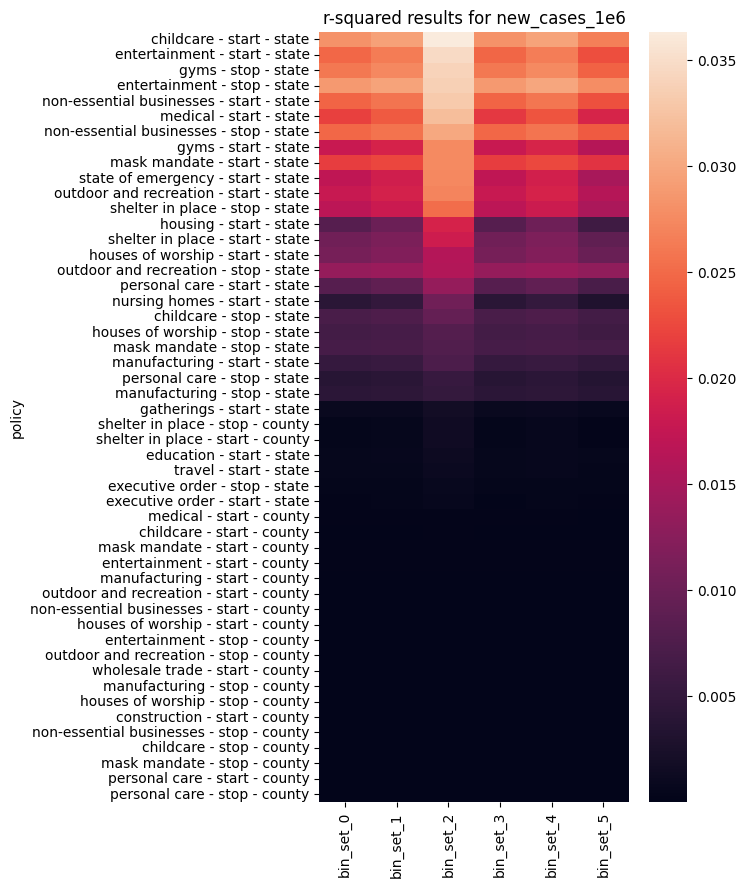

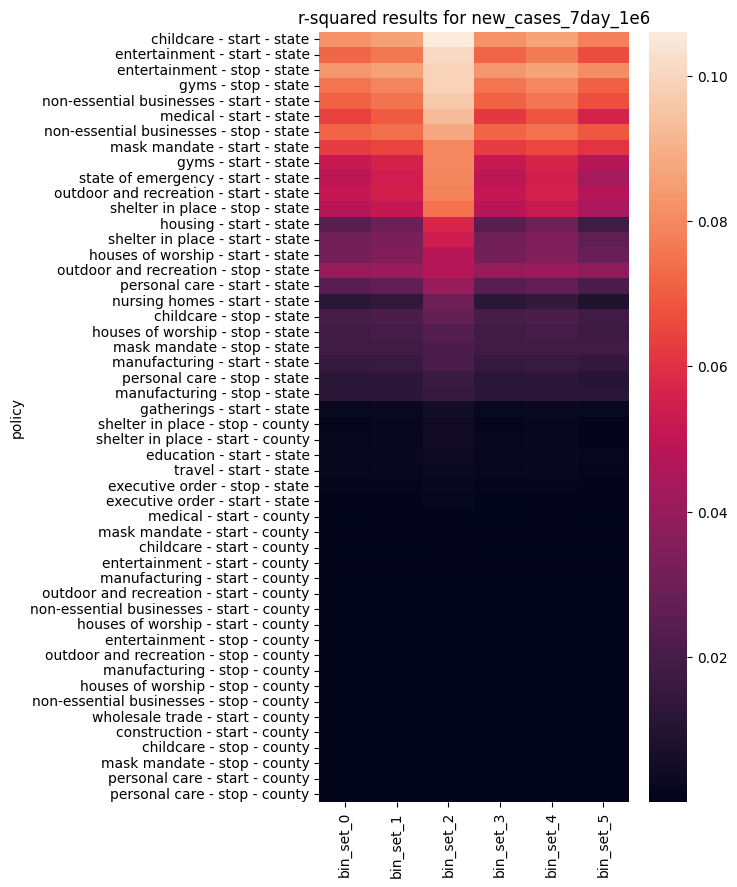

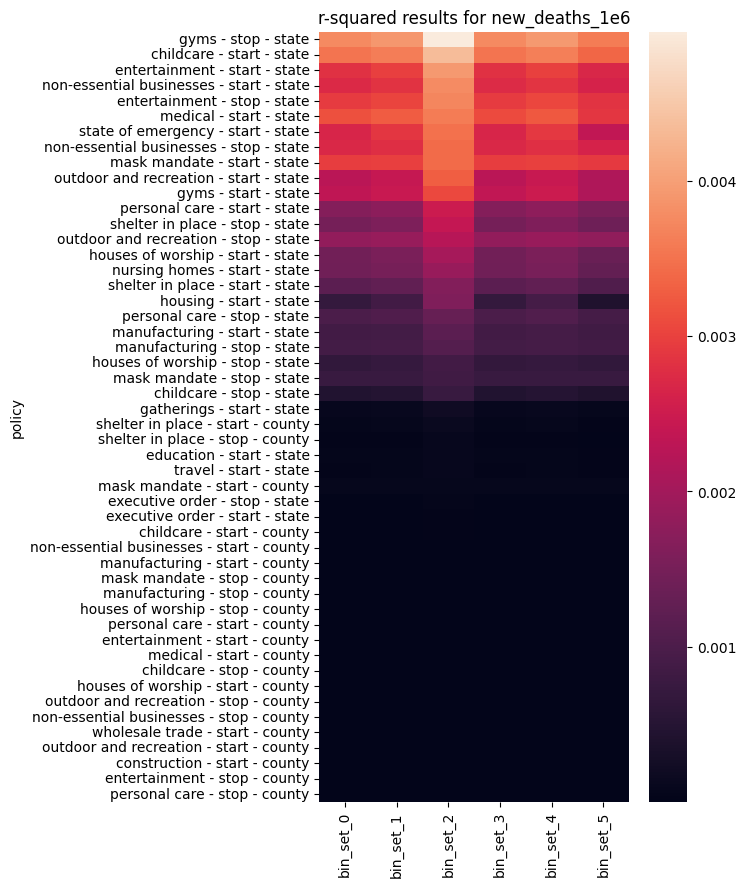

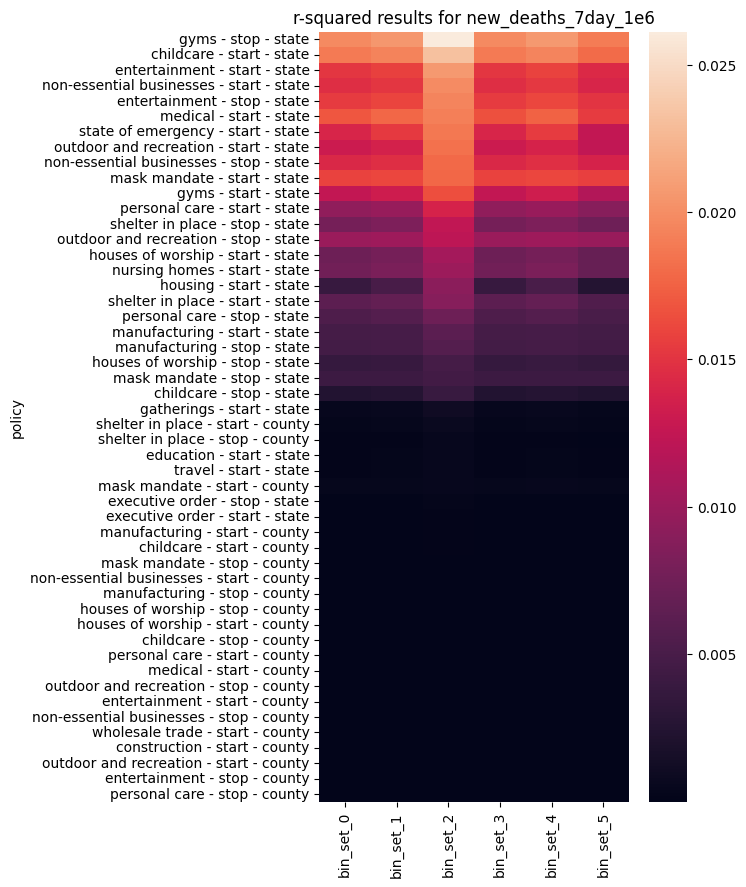

In [9]:

dep_vars = [
    'new_cases_1e6',
    'new_cases_7day_1e6',
    'new_deaths_1e6',
    'new_deaths_7day_1e6'
]

for var in dep_vars:
    _, bins_ids = plot_rsquared_heatmap(
        data = df,
        dep_var = var,
        sort_values = True,
        ax = None
    )

In [10]:
bins_ids

{'bin_set_0': '[(0, 14), (15, 999)]',
 'bin_set_1': '[(0, 20), (21, 999)]',
 'bin_set_2': '[(0, 7), (8, 14), (15, 28), (29, 60), (61, 999)]',
 'bin_set_3': '[(0, 7), (8, 14), (15, 999)]',
 'bin_set_4': '[(0, 7), (8, 21), (22, 999)]',
 'bin_set_5': '[(0, 7), (8, 999)]'}

Most of these models have a very low R-squared. This isn't surprising since we're fitting number of cases / deaths on a few dummy variables, so there's a lot of variation that the models are not accounting for.

# 3. Model Diagnostics

In [11]:
from covid_project.regression_funcs_bins import get_single_policy_regression_data, fit_ols_model_single_policy
bins = [(0, 7), (8, 14), (15, 28), (29, 60), (61, 999)]
dep_var = 'new_cases_1e6'


In [14]:
def plot_pred_vs_residuals(policy, dep_var, bins, ax):
    succ, data = get_single_policy_regression_data(policy, bins)
    if not succ:
        return ax
    results = fit_ols_model_single_policy(
        data,
        policy,
        dep_var,
        True,
        True)
    ax.scatter(results['predictions'], results['residuals'])
    ax.set_title(policy)
    ax.set_ylabel("residuals")
    ax.set_xlabel("predictions")
    return ax

## 3.1 Linear relationship

Check for a linear relationship by plotting the residuals vs. predicted values. This plot should look like a straight line.

  0%|          | 0/48 [00:00<?, ?it/s]

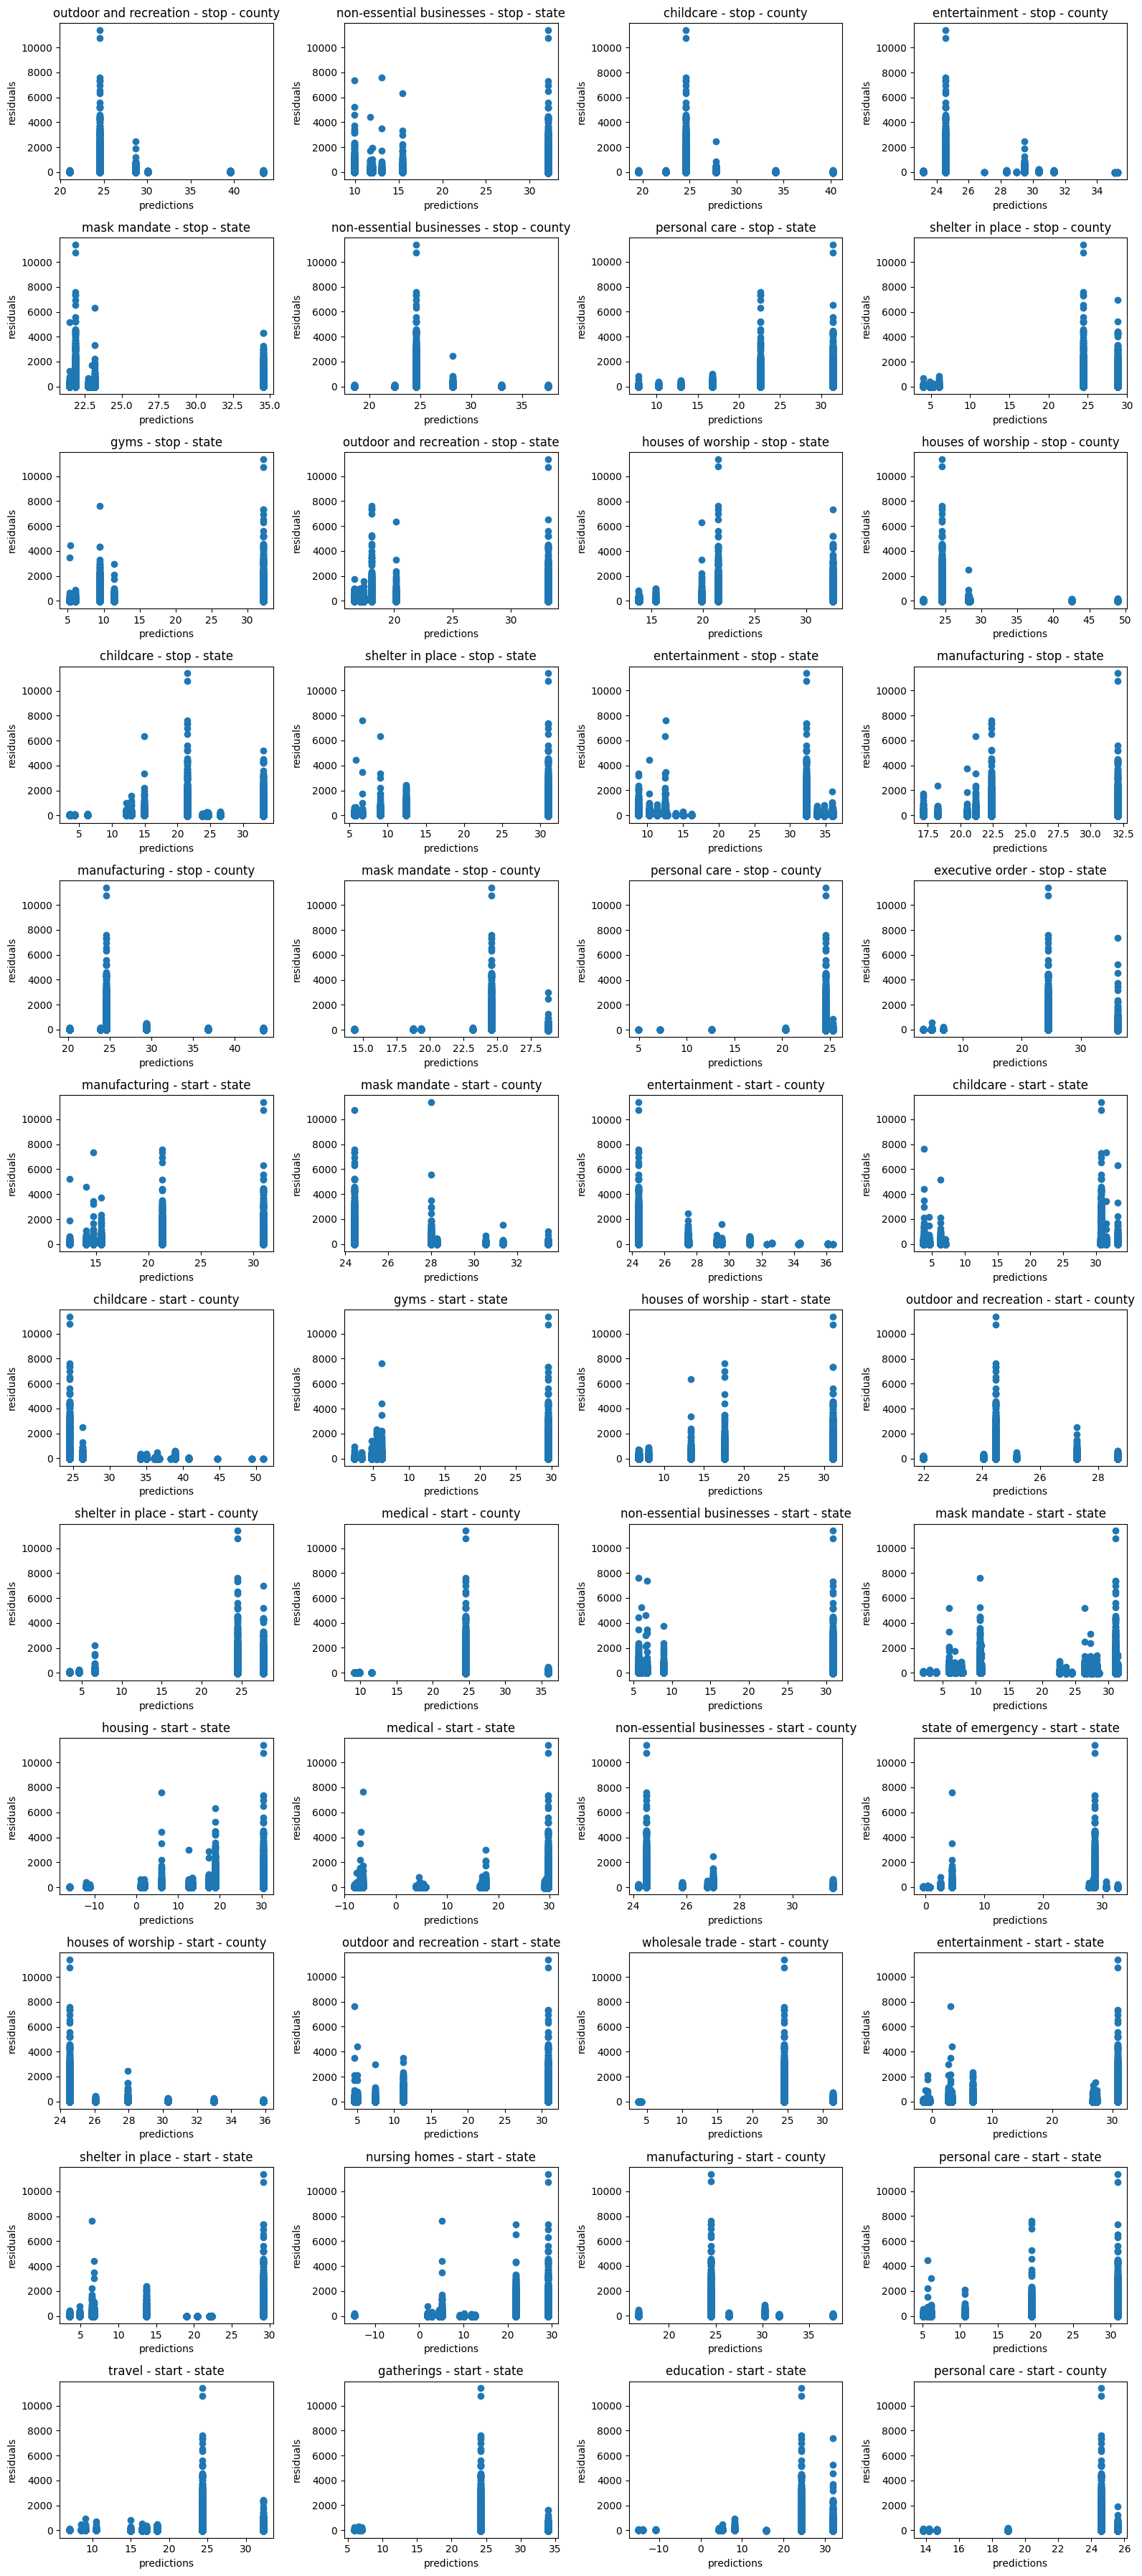

In [15]:
policies = df[df['bins_list']==str(bins)]['policy'].unique()

fig, axes = plt.subplots(nrows = len(policies)//4, ncols=4, figsize=[16, 3*(len(policies)//4)])

for i, ax in enumerate(tqdm(axes.flatten())):
    if i > len(policies):
        continue
    policy = policies[i]
    plot_pred_vs_residuals(policy, 'new_cases_1e6', bins, ax)

fig.tight_layout()

# 4. Conclusions

I attempted to build a simple linear regression model to infer the impact that covid policies had on the spread of the pandemic. I used a series of "bins" to set up dummy variables that encode how long it has been since a policy was implemented. Due to computational constraints, I trained only on individual policies. 

I observed that most of the fitted coefficients had signficant p-values, however most of these models are plagued with very low R-squared values and the dataset itself appears nonlinear. This suggests that the model itself is invalid and other approaches should be attempted. 
